In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import OPTICS

In [89]:
data = pd.read_csv('a.csv', sep=",", encoding="ISO-8859-1", header=0)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
# shape of df
data.shape

(541909, 8)

In [4]:
# df info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# df description
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# DATA PREPROCESSING

In [6]:
data_null = data.isnull().sum()
data_null

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
# Droping rows having missing values

data = data.dropna(subset="CustomerID", axis=0)
data.shape

(406829, 8)

In [9]:
data_null = data.isnull().sum()
data_null

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [10]:
# Finding duplicate values
print(data.duplicated().sum())

5225


In [11]:
#Dropping duplicate values
data = data.drop_duplicates(keep="first")
data.shape

(401604, 8)

In [12]:
# Finding duplicate values
print(data.duplicated().sum())

0


In [13]:
# Changing the datatype of Customer Id as per Business understanding
data['CustomerID'] = data['CustomerID'].astype(str)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  object 
 7   Country      401604 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 27.6+ MB


In [15]:
#Removing canclled product from invoice
data = data[~data.InvoiceNo.str.contains('C',na=False)]
data.shape

(392732, 8)

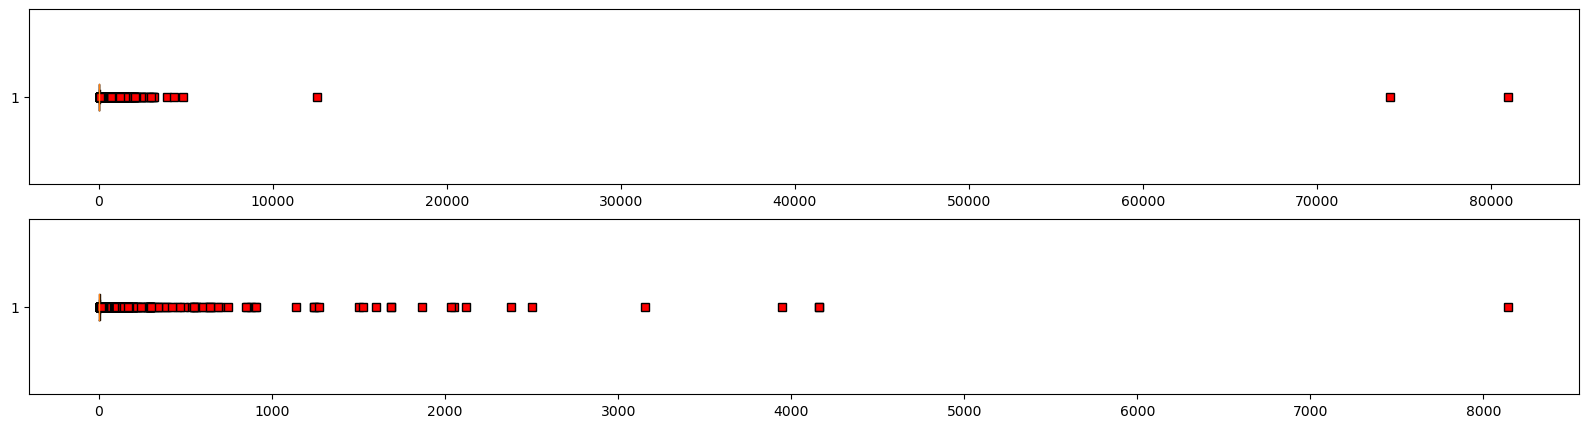

In [16]:
# Observing them before removing outliers.
f, ax = plt.subplots(2,1, figsize = (20,5))
col_list = ["Quantity","UnitPrice"]
for i in range(0,2):
    ax[i].boxplot(data[col_list[i]],flierprops = dict(marker = "s", markerfacecolor = "red"), vert = 0)
plt.show()

In [17]:
def remove_outliers(data, col_name, threshold=1.5):
    
    Q1 = np.percentile(data[col_name], 25)
    Q3 = np.percentile(data[col_name], 75)

    IQR = Q3 - Q1

    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    filtered_data = data[(data[col_name] >= lower_bound) & (data[col_name] <= upper_bound)]

    return filtered_data

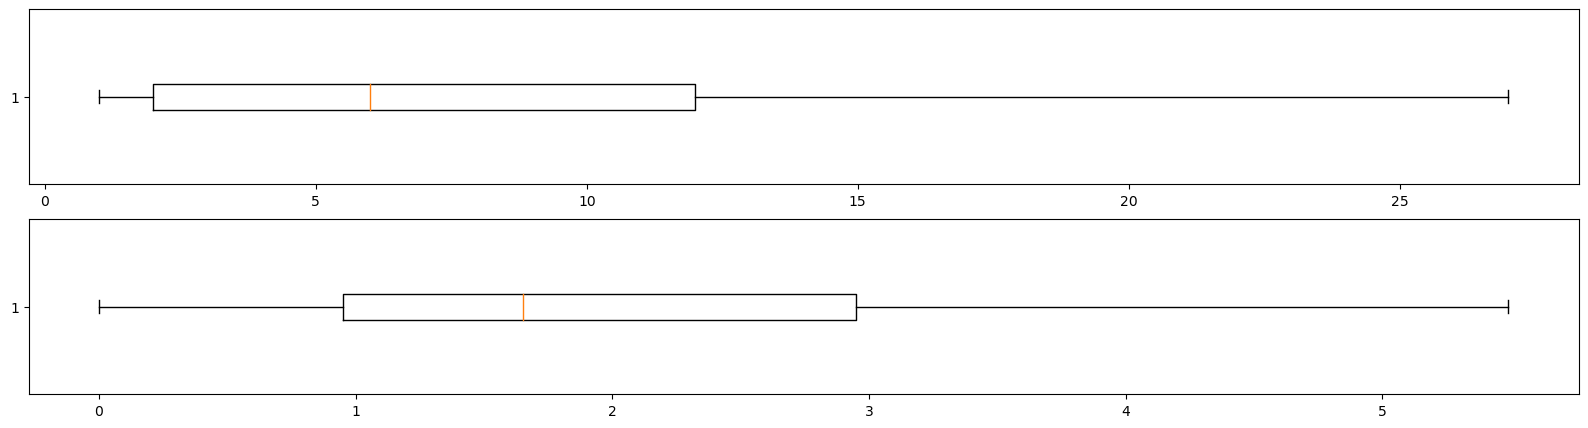

In [72]:
data=remove_outliers(data, "Quantity")
data=remove_outliers(data, "UnitPrice")
f, ax = plt.subplots(2,1, figsize = (20,5))
for i in range(0,2):
    ax[i].boxplot(data[col_list[i]],flierprops = dict(marker = "s", markerfacecolor = "red"), vert = 0)
plt.show()

In [19]:
data.shape

(333265, 8)

# DATA PREPARATION

In [20]:
# New Attribute : Monetary

data['Amount'] = data['Quantity']*data['UnitPrice']
rfm_m = data.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12347.0,3314.73
1,12348.0,90.20
2,12349.0,999.15
3,12350.0,294.40
4,12352.0,1130.94


In [21]:
# New Attribute : Frequency

rfm_f = data.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12347.0,166
1,12348.0,6
2,12349.0,58
3,12350.0,16
4,12352.0,66


In [22]:
# Merging the two dfs
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12347.0,3314.73,166
1,12348.0,90.20,6
2,12349.0,999.15,58
3,12350.0,294.40,16
4,12352.0,1130.94,66


In [23]:
# New Attribute : Recency
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [24]:
# Compute the maximum date to know the last transaction date
max_date = max(data['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [70]:
# Compute the difference between max date and transaction date
max_date = dt.datetime(2011, 12, 9)
data['Diff'] = max_date - data['InvoiceDate']

In [69]:
# Compute last transaction date to get the recency of customers

rfm_p = data.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12347.0,1 days 08:08:00
1,12348.0,247 days 13:13:00
2,12349.0,17 days 14:09:00
3,12350.0,309 days 07:59:00
4,12352.0,35 days 09:23:00


In [27]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12347.0,1
1,12348.0,247
2,12349.0,17
3,12350.0,309
4,12352.0,35


In [28]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12347.0,3314.73,166,1
1,12348.0,90.20,6,247
2,12349.0,999.15,58,17
3,12350.0,294.40,16,309
4,12352.0,1130.94,66,35


Text(0.5, 0, 'Attributes')

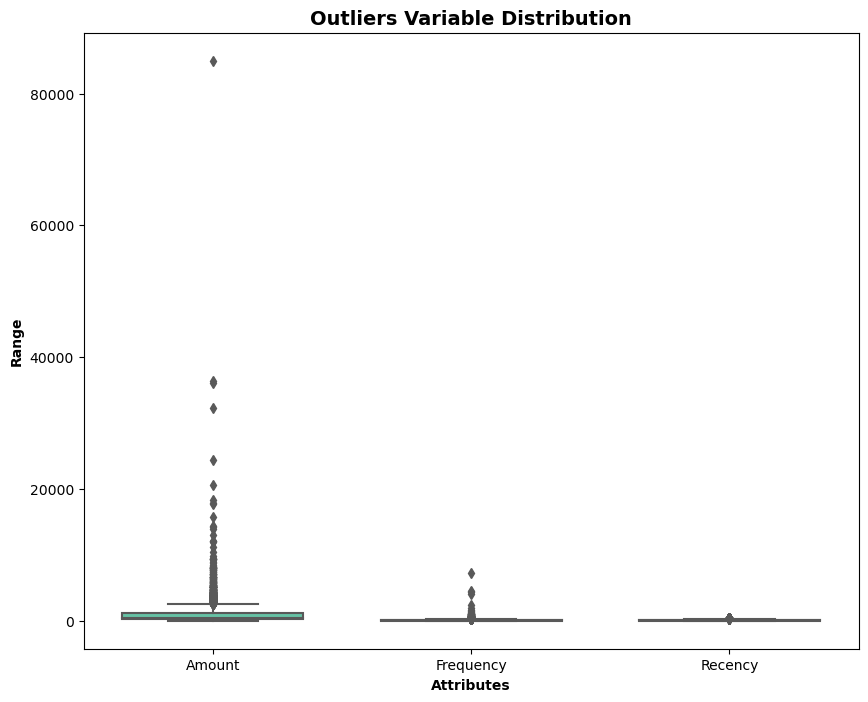

In [29]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [30]:
def remove_RFMoutliers(data, col_name, threshold=1.5):
    
    Q1 = np.percentile(data[col_name], 5)
    Q3 = np.percentile(data[col_name], 95)

    IQR = Q3 - Q1

    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    filtered_RFMdata = data[(data[col_name] >= lower_bound) & (data[col_name] <= upper_bound)]

    return filtered_RFMdata

In [31]:
rfm=remove_RFMoutliers(rfm, "Amount")
rfm=remove_RFMoutliers(rfm, "Frequency")
rfm=remove_RFMoutliers(rfm, "Recency")

In [73]:
# Rescaling the attributes using Standardisation (mean-0, sigma-1)

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]
scaler = StandardScaler()
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4141, 3)

In [33]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,2.100652,1.168732,-0.909874
1,-0.694066,-0.711524,1.549060
2,0.093726,-0.100441,-0.749943
3,-0.517085,-0.594008,2.168792
4,0.207949,-0.006428,-0.570021


# BUILDING THE MODELS

### K-MEANS CLUSTERING

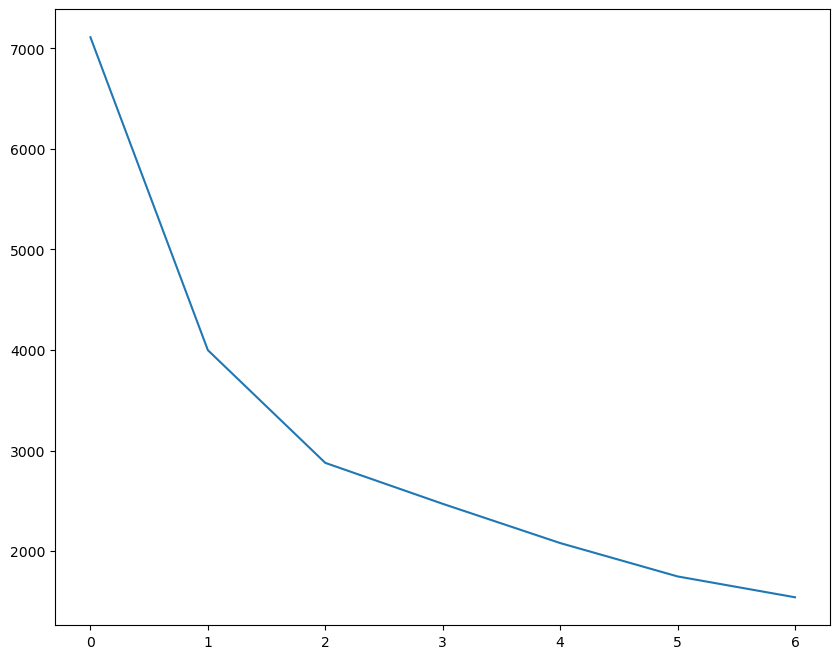

In [34]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
plt.plot(ssd)

As we can observe from the grapgh above that elbow is observed around 2, to confirm this we will now use Silhouette Method

In [35]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters,n_init=10, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))    

For n_clusters=2, the silhouette score is 0.542546790861092
For n_clusters=3, the silhouette score is 0.510302904517423
For n_clusters=4, the silhouette score is 0.48752772169434955
For n_clusters=5, the silhouette score is 0.4833707522142236
For n_clusters=6, the silhouette score is 0.4271875113238941


In [81]:
# Final model with k=2 since it is more close to 1
kmeans = KMeans(n_clusters=2,n_init=10, max_iter=50)
kmeans.fit(rfm_df_scaled)
kmeans.labels_

array([1, 0, 0, ..., 0, 0, 0])

In [37]:
# assign the label
rfm['KMeans_label'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,KMeans_label
0,12347.0,3314.73,166,1,0
1,12348.0,90.20,6,247,1
2,12349.0,999.15,58,17,1
3,12350.0,294.40,16,309,1
4,12352.0,1130.94,66,35,1


<Axes: xlabel='KMeans_label', ylabel='Amount'>

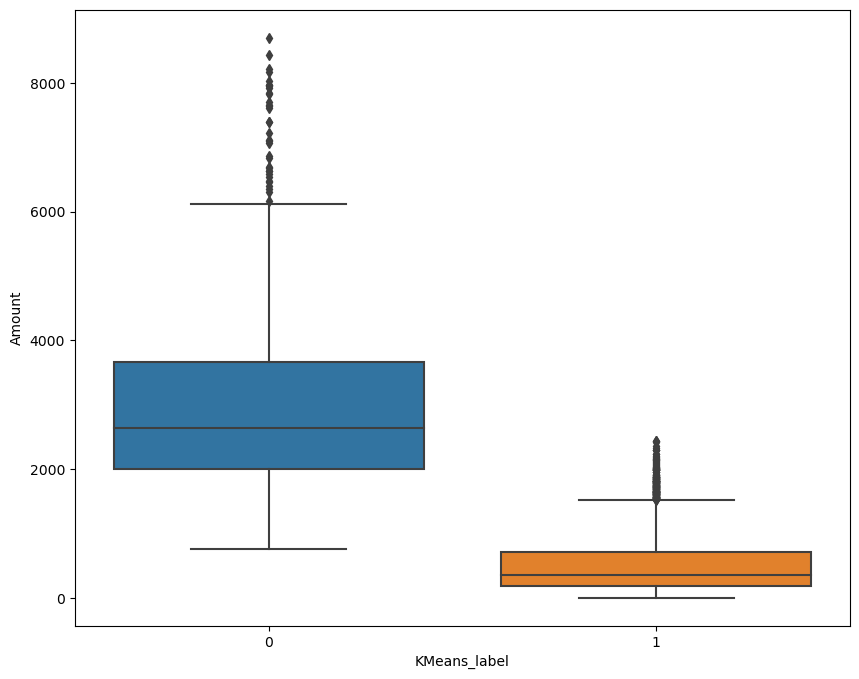

In [38]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='KMeans_label', y='Amount', data=rfm)

<Axes: xlabel='KMeans_label', ylabel='Frequency'>

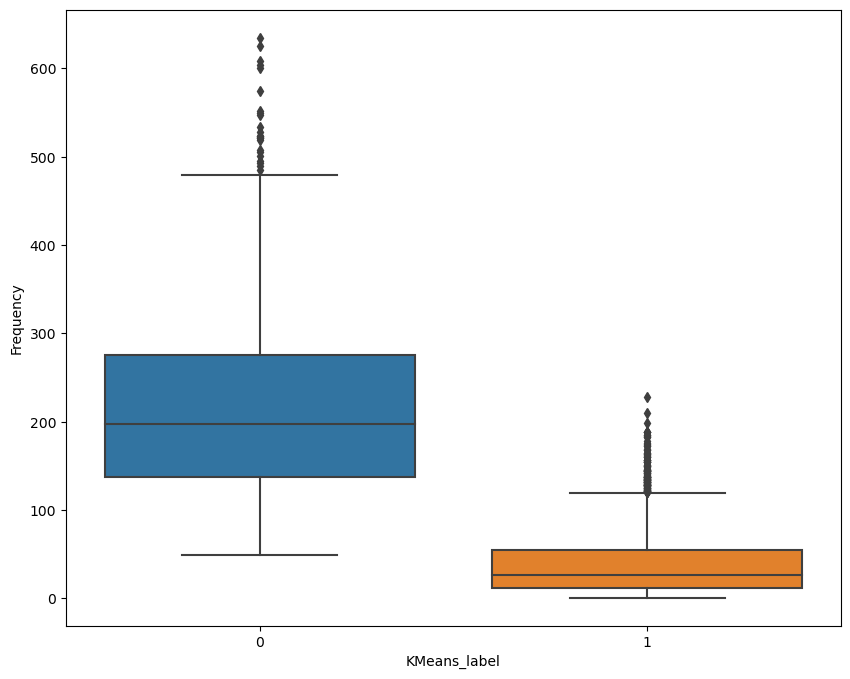

In [39]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='KMeans_label', y='Frequency', data=rfm)

<Axes: xlabel='KMeans_label', ylabel='Recency'>

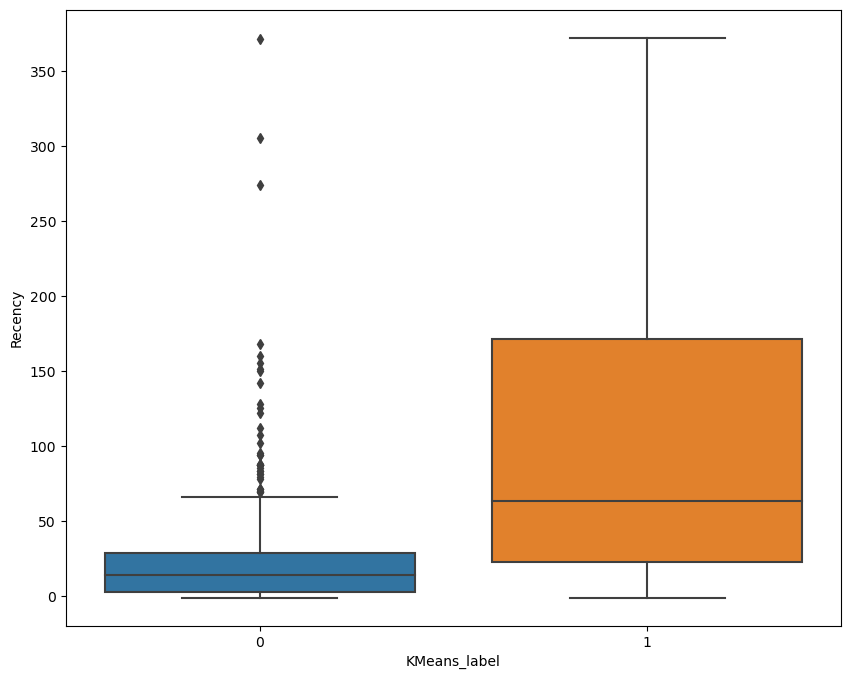

In [40]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='KMeans_label', y='Recency', data=rfm)

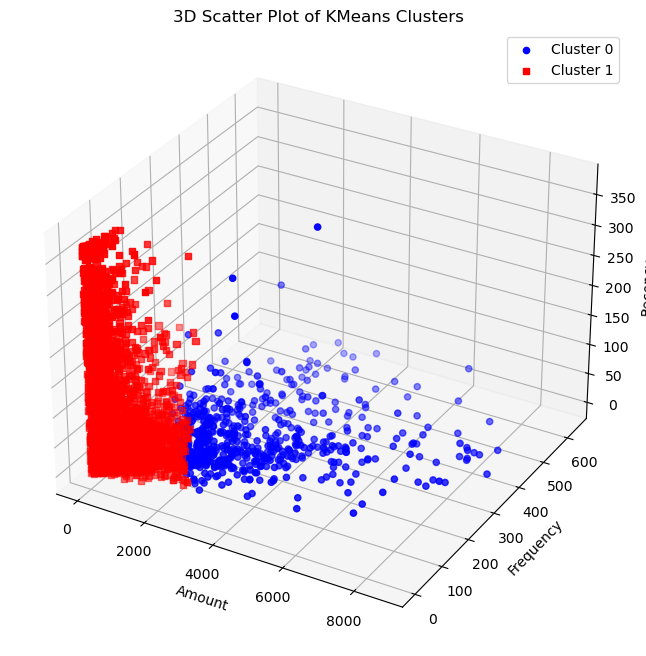

In [84]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm.loc[rfm['KMeans_label'] == 0, 'Amount'],
           rfm.loc[rfm['KMeans_label'] == 0, 'Frequency'],
           rfm.loc[rfm['KMeans_label'] == 0, 'Recency'],
           c='blue', marker='o', label='Cluster 0')
ax.scatter(rfm.loc[rfm['KMeans_label'] == 1, 'Amount'],
           rfm.loc[rfm['KMeans_label'] == 1, 'Frequency'],
           rfm.loc[rfm['KMeans_label'] == 1, 'Recency'],
           c='red', marker='s', label='Cluster 1')
ax.set_xlabel('Amount')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.set_title('3D Scatter Plot of KMeans Clusters')
ax.legend()
plt.show()

### HIERARICAL CLUSTERING ALGORITHMS

#### SINGLE LINKAGE

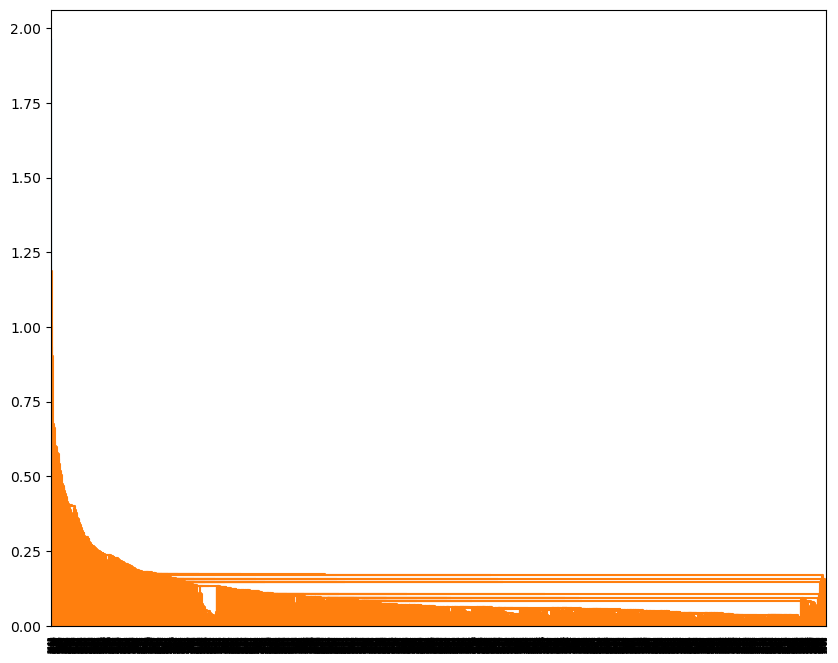

In [87]:
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

SINCE IT IS GIVING ONLY ONE CLUSTER, WE WILL GO FOR COMPLETE LINKAGE

#### COMPLETE LINKAGE

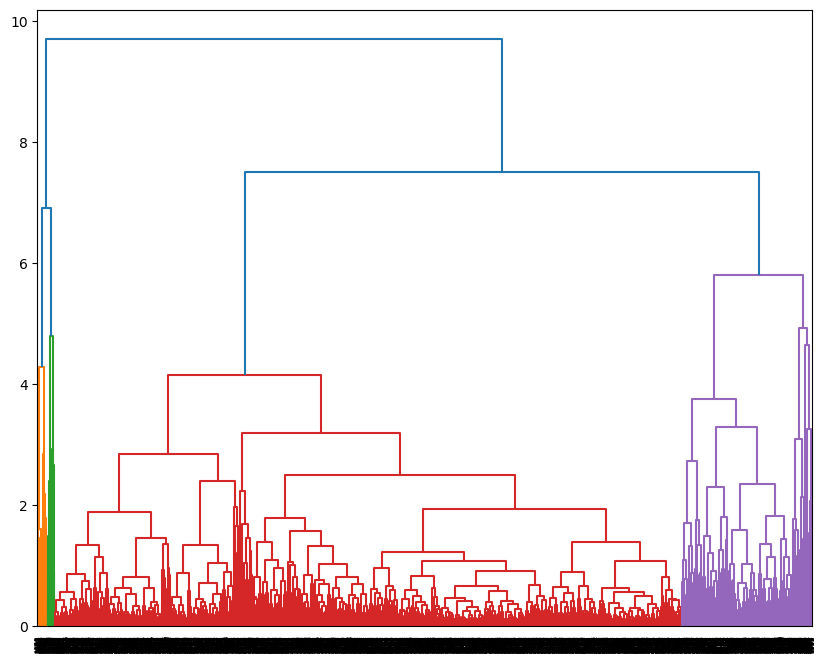

In [42]:
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

FINDING THE VALUE OF K FOR THE COMPLETE LINKAGE USING SILHOUETTE METHOD

In [43]:
range_n_clusters = [2, 3, 4, 5, 6]

for num_clusters in range_n_clusters:
    mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')    
    cluster_labels = cut_tree(mergings, n_clusters=num_clusters).reshape(-1, )
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.6502718417108674
For n_clusters=3, the silhouette score is 0.4603218738991324
For n_clusters=4, the silhouette score is 0.45961420937379716
For n_clusters=5, the silhouette score is 0.40795484112894886
For n_clusters=6, the silhouette score is 0.40590560173014945


In [44]:
#3cutting clusters with k = 2 since it is more close to 1
cluster_labels = cut_tree(mergings, n_clusters=2).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [45]:
# Assign cluster labels

rfm['Hierarchical_label'] = cluster_labels
rfm.head()

,CustomerID,Amount,Frequency,Recency,KMeans_label,Hierarchical_label
0,12347.0,3314.73,166,1,0,0
1,12348.0,90.20,6,247,1,0
2,12349.0,999.15,58,17,1,0
3,12350.0,294.40,16,309,1,0
4,12352.0,1130.94,66,35,1,0


<Axes: xlabel='Hierarchical_label', ylabel='Amount'>

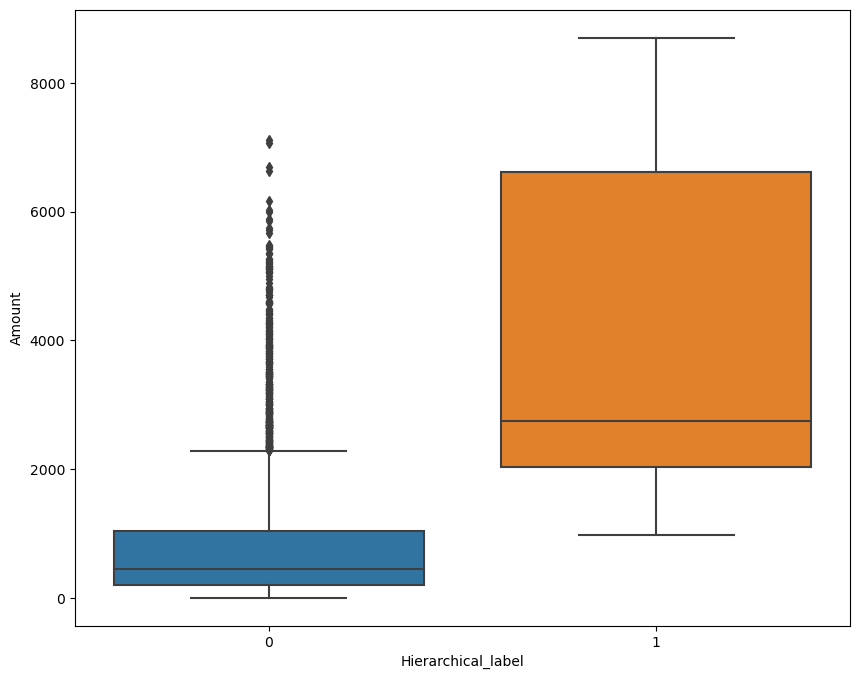

In [46]:
# Plot Cluster Id vs Amount

sns.boxplot(x='Hierarchical_label', y='Amount', data=rfm)

<Axes: xlabel='Hierarchical_label', ylabel='Frequency'>

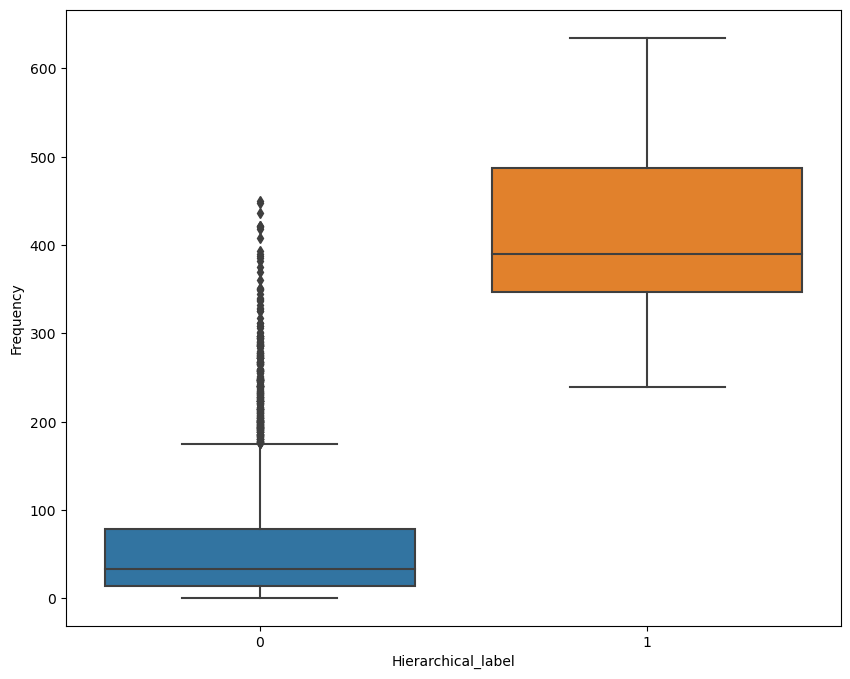

In [47]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='Hierarchical_label', y='Frequency', data=rfm)

<Axes: xlabel='Hierarchical_label', ylabel='Recency'>

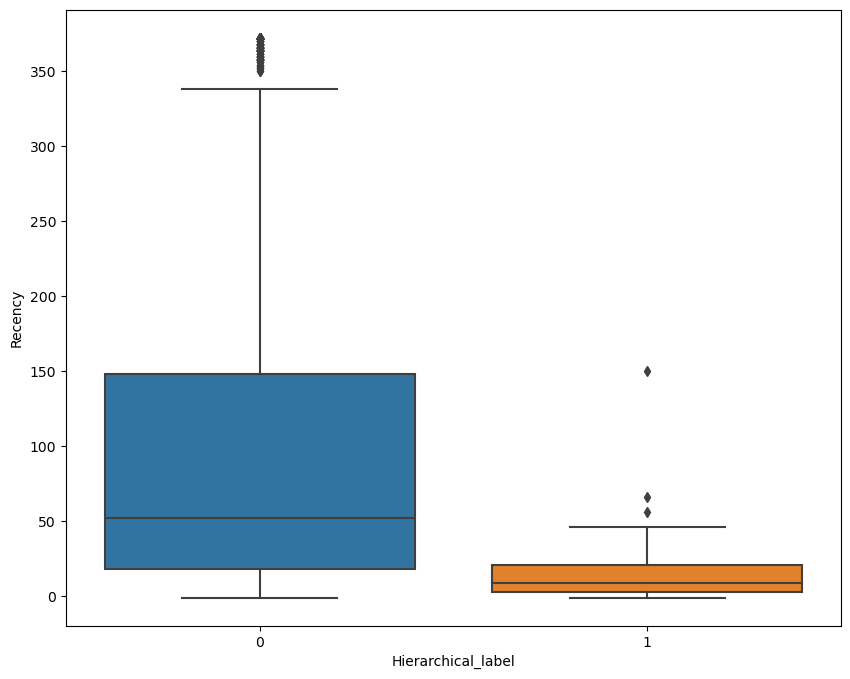

In [48]:
# Plot Cluster Id vs Recency
sns.boxplot(x='Hierarchical_label', y='Recency', data=rfm)

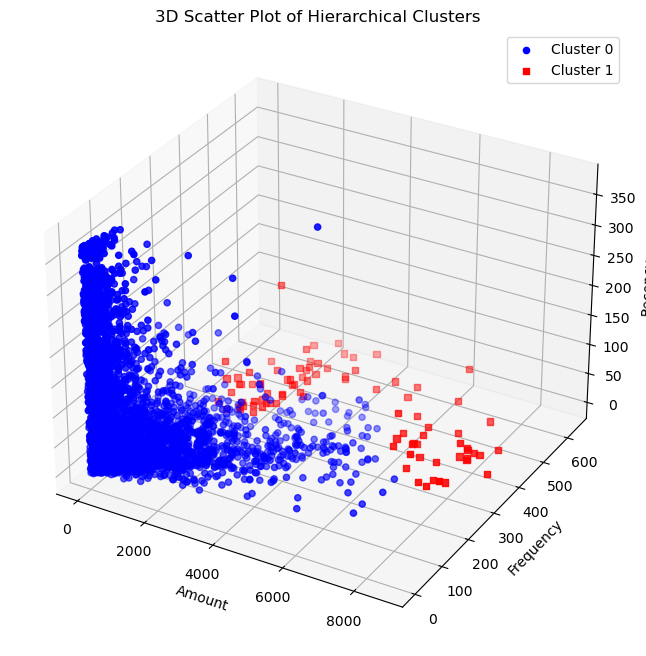

In [85]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm.loc[cluster_labels == 0, 'Amount'],
           rfm.loc[cluster_labels == 0, 'Frequency'],
           rfm.loc[cluster_labels == 0, 'Recency'],
           c='blue', marker='o', label='Cluster 0')
ax.scatter(rfm.loc[cluster_labels == 1, 'Amount'],
           rfm.loc[cluster_labels == 1, 'Frequency'],
           rfm.loc[cluster_labels == 1, 'Recency'],
           c='red', marker='s', label='Cluster 1')
ax.set_xlabel('Amount')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.set_title('3D Scatter Plot of Hierarchical Clusters')
ax.legend()
plt.show()

### DBSCAN

Minimum samples, is giving by the number of attributes + 1
And for the value of epsilon we will use K distace graph and silhouette moethod 

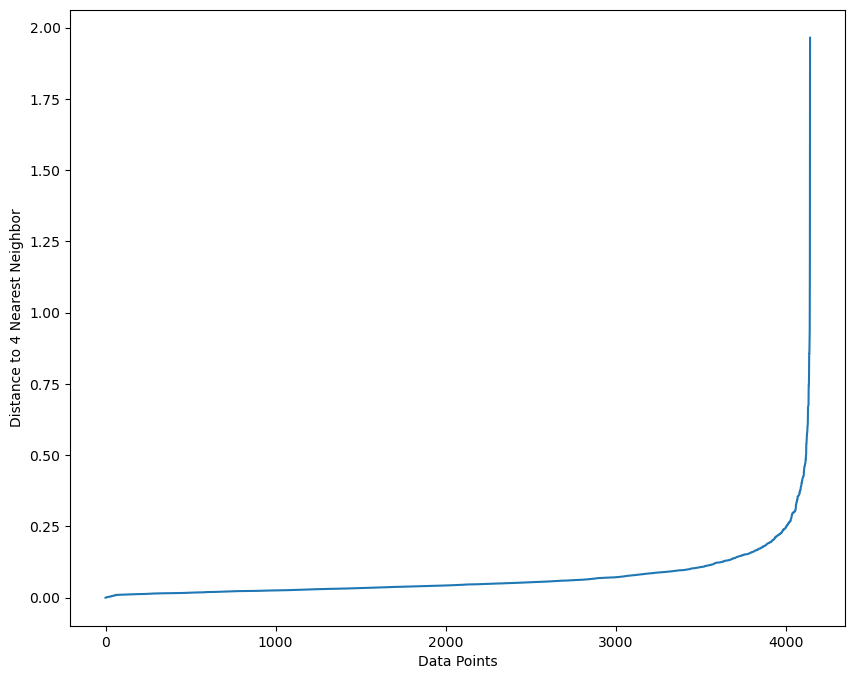

In [53]:
nbrs = NearestNeighbors(n_neighbors=4).fit(rfm_df_scaled)
distances, indices = nbrs.kneighbors(rfm_df_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel(f'Distance to 4 Nearest Neighbor')

plt.show()

From the above plot steep curve is observed around o.25, to get the exact value we will use silhoutte scores

In [55]:
epsilons = [0.15, 0.20, 0.25, 0.30, 0.35, 0.5]

best_epsilon = None
best_score = -1

for epsilon in epsilons:
    dbscan = DBSCAN(eps=epsilon, min_samples=4)
    labels = dbscan.fit_predict(rfm_df_scaled)
    unique_labels = len(set(labels))
    if unique_labels == 1:
        continue
    silhouette_avg = silhouette_score(rfm_df_scaled, labels)
    print(list(set(labels)))
    print(f'Epsilon: {epsilon}, C Score: {silhouette_avg}')
    
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_epsilon = epsilon

print(f'Best Epsilon: {best_epsilon}, Best Silhouette Score: {best_score}')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, -1]
Epsilon: 0.15, C Score: -0.4057483807548958
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1]
Epsilon: 0.2, C Score: -0.14204245546798946
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, -1]
Epsilon: 0.25, C Score: -0.04944642074079493
[0, 1, 2, 3, 4, 5, 6, 7, 8, -1]
Epsilon: 0.3, C Score: 0.03810302412484938
[0, 1, 2, 3, 4, 5, 6, -1]
Epsilon: 0.35, C Score: 0.5322899635359192
[0, 1, 2, -1]
Epsilon: 0.5, C Score: 0.5990385462565615
Best Epsilon: 0.5, Best Silhouette Score: 0.5990385462565615


In [57]:
#Final model with epsilon=0.5 and min_samples=4
dbscan = DBSCAN(eps=0.5, min_samples=4)
labels = dbscan.fit_predict(rfm_df_scaled)
print(list(set(labels)))

[0, 1, 2, -1]


In [58]:
# Assign cluster labels

rfm['DBSCAN_label'] = labels
rfm.head()

,CustomerID,Amount,Frequency,Recency,KMeans_label,Hierarchical_label,DBSCAN_label
0,12347.0,3314.73,166,1,0,0,0
1,12348.0,90.20,6,247,1,0,0
2,12349.0,999.15,58,17,1,0,0
3,12350.0,294.40,16,309,1,0,0
4,12352.0,1130.94,66,35,1,0,0


<Axes: xlabel='DBSCAN_label', ylabel='Amount'>

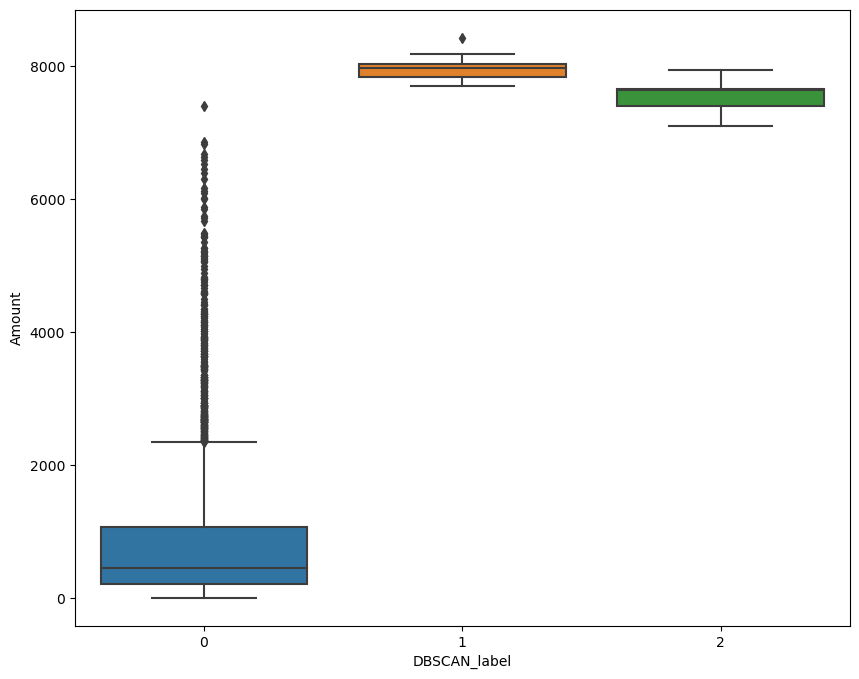

In [59]:
# Plot Cluster Id vs Amount

sns.boxplot(x='DBSCAN_label', y='Amount', data=rfm[rfm['DBSCAN_label'] != -1])

<Axes: xlabel='DBSCAN_label', ylabel='Frequency'>

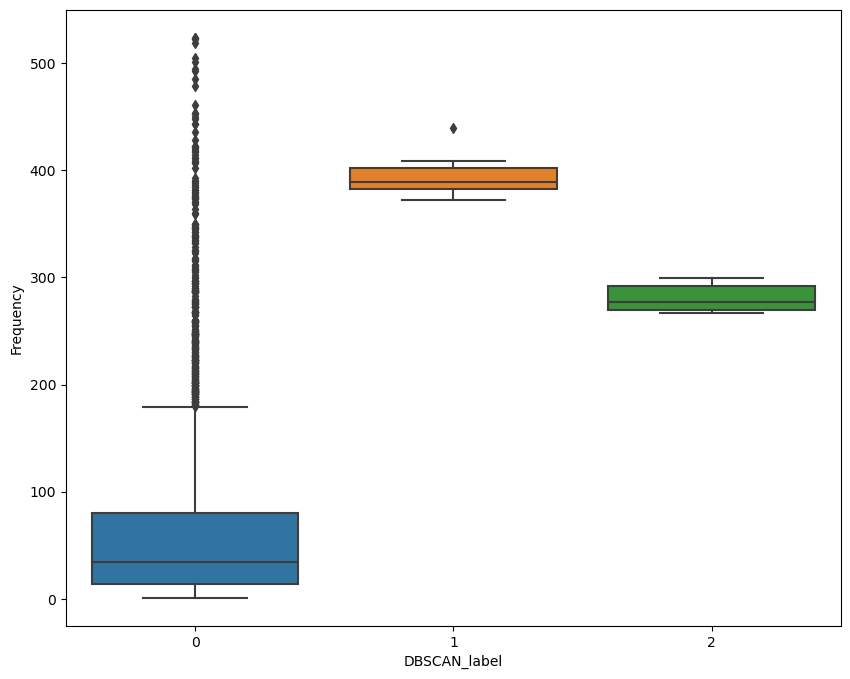

In [60]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='DBSCAN_label', y='Frequency', data=rfm[rfm['DBSCAN_label'] != -1])

<Axes: xlabel='DBSCAN_label', ylabel='Recency'>

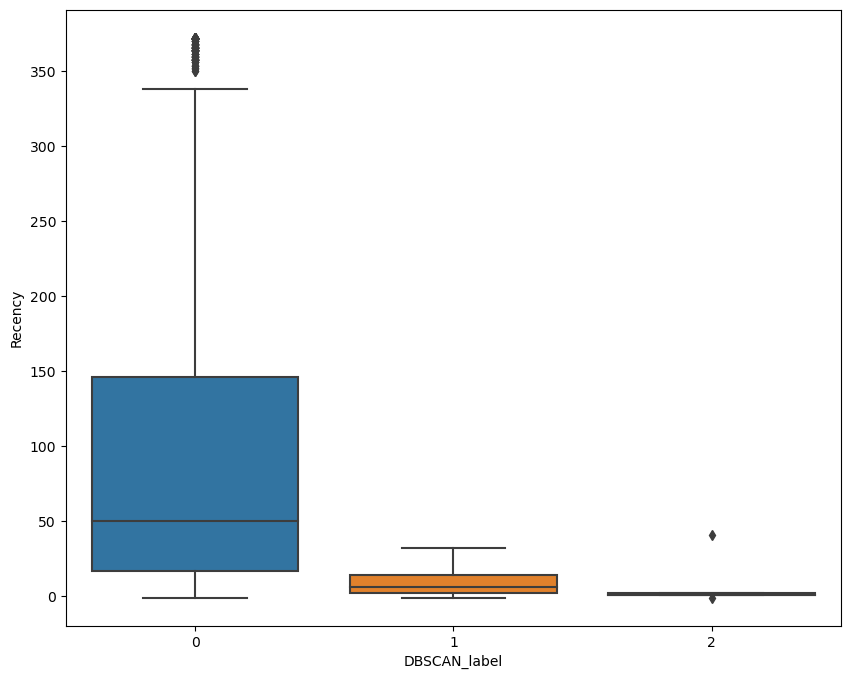

In [61]:
# Plot Cluster Id vs Recency

sns.boxplot(x='DBSCAN_label', y='Recency', data=rfm[rfm['DBSCAN_label'] != -1])

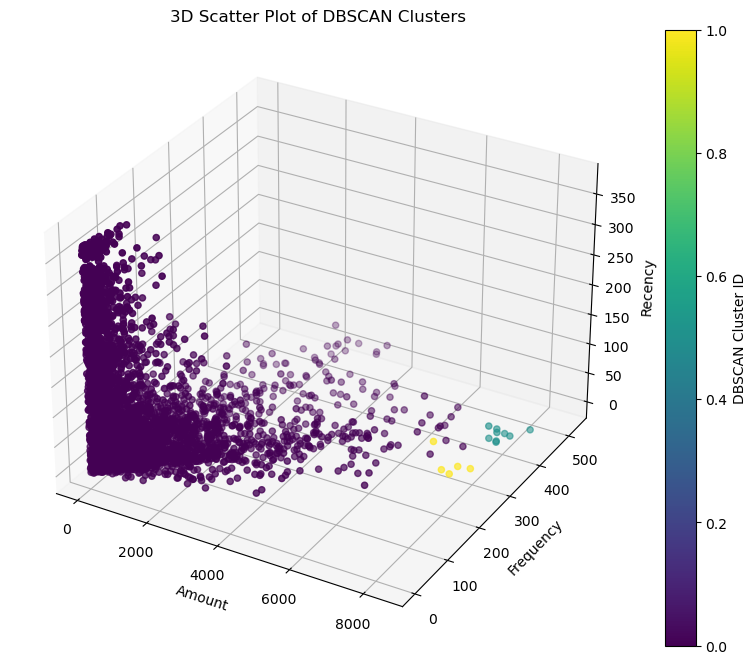

In [86]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'rfm' is your DataFrame with the DBSCAN labels
# and 'rfm_df_scaled' is the scaled data

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for DBSCAN labeled points (excluding noise points with label -1)
ax.scatter(rfm.loc[rfm['DBSCAN_label'] != -1, 'Amount'],
           rfm.loc[rfm['DBSCAN_label'] != -1, 'Frequency'],
           rfm.loc[rfm['DBSCAN_label'] != -1, 'Recency'],
           c=rfm.loc[rfm['DBSCAN_label'] != -1, 'DBSCAN_label'], cmap='viridis', marker='o', label='DBSCAN Clusters')

# Set labels and title
ax.set_xlabel('Amount')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.set_title('3D Scatter Plot of DBSCAN Clusters')

# Add a colorbar
cbar = plt.colorbar(ax.scatter([], [], [], c=[], cmap='viridis'))
cbar.set_label('DBSCAN Cluster ID')

# Show the plot
plt.show()

# ANALYSIS

### Silhouette Analysis:

In [64]:
from sklearn.cluster import AgglomerativeClustering

n_clusters_km = 2
n_clusters_cl = 3

# Initialize lists to store silhouette scores for each algorithm
silhouette_scores_kmeans = []
silhouette_scores_agglomerative = []
silhouette_scores_dbscan = []

# K-means
kmeans = KMeans(n_clusters=n_clusters_km)
kmeans_labels = kmeans.fit_predict(rfm_df_scaled)
silhouette_scores_kmeans.append(silhouette_score(rfm_df_scaled, kmeans_labels))

#complete linkage
complete_linkage = AgglomerativeClustering(n_clusters=n_clusters_cl, linkage='complete')
complete_linkage_labels = complete_linkage.fit_predict(rfm_df_scaled)
silhouette_scores_complete_linkage = silhouette_score(rfm_df_scaled, complete_linkage_labels)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=4)
dbscan_labels = dbscan.fit_predict(rfm_df_scaled)
silhouette_scores_dbscan.append(silhouette_score(rfm_df_scaled, dbscan_labels))

# Print Silhouette Scores
print(f"Silhouette Score for K-means (with {n_clusters_km} clusters): {silhouette_scores_kmeans[0]}")
print(f"Silhouette Score for Agglomerative Clustering (with {n_clusters_cl} clusters): {silhouette_scores_complete_linkage}")
print(f"Silhouette Score for DBSCAN (with {n_clusters_cl} clusters): {silhouette_scores_dbscan[0]}")

C:\Users\khadi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for K-means (with 2 clusters): 0.542546790861092
Silhouette Score for Agglomerative Clustering (with 3 clusters): 0.4603218738991324
Silhouette Score for DBSCAN (with 3 clusters): 0.5990385462565615


It shows DBSCAN has got better defined clusters

### Davies-Bouldin

In [90]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score

# Apply clustering algorithms
kmeans = KMeans(n_clusters=2, random_state=42)
agglomerative = AgglomerativeClustering(n_clusters=3)
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit and predict clusters
kmeans_labels = kmeans.fit_predict(rfm_df_scaled)
agglomerative_labels = agglomerative.fit_predict(rfm_df_scaled)
dbscan_labels = dbscan.fit_predict(rfm_df_scaled)

# Calculate Davies-Bouldin Index
db_kmeans = davies_bouldin_score(rfm_df_scaled, kmeans_labels)
db_agglomerative = davies_bouldin_score(rfm_df_scaled, agglomerative_labels)
db_dbscan = davies_bouldin_score(rfm_df_scaled, dbscan_labels)

# Print or analyze the Davies-Bouldin Index
print("Davies-Bouldin Index for KMeans:", db_kmeans)
print("Davies-Bouldin Index for Hierarichal Clustering:", db_agglomerative)
print("Davies-Bouldin Index for DBSCAN:", db_dbscan)


C:\Users\khadi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Davies-Bouldin Index for KMeans: 0.849011627149492
Davies-Bouldin Index for Hierarichal Clustering: 0.7229254381840313
Davies-Bouldin Index for DBSCAN: 1.31563170272209


### Cophenetic Correlation Coefficient for hierarical 

In [83]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

coph_coeff, coph_dist = cophenet(mergings, pdist(rfm_df_scaled))
print(f'Cophenetic Correlation Coefficient: {coph_coeff}')

Cophenetic Correlation Coefficient: 0.7469492809415129
